# Imports

In [1]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from src.preprocessing import preprocess_data
from src.utils.compute_metrics import compute_and_store_metrics
from src.utils.confusion_matrix import plot_confusion_matrix
from src.utils.load_data import load_data
from src.utils.save_model import save_model


# Load Data

In [2]:
X, y = preprocess_data(load_data())

# Model

## Basic Random Forest Classifier

In [3]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

### Evaluation

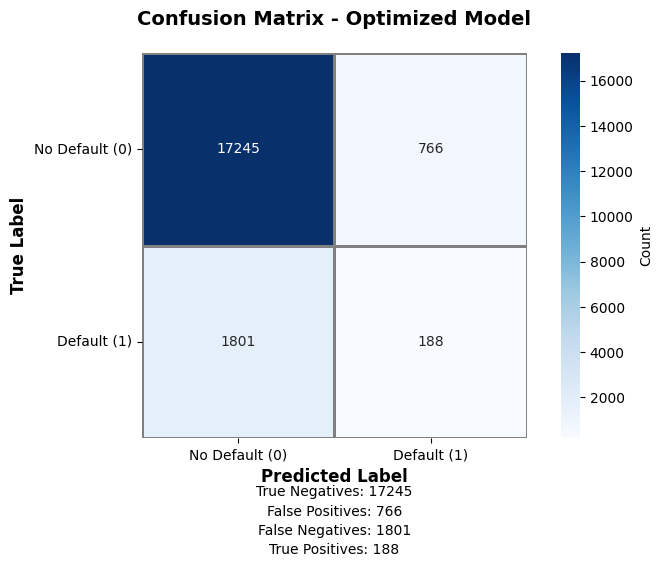


Model Metrics:
Accuracy:  0.8717 (87.17%)
Precision: 0.1971 (19.71%)
Recall:    0.0945 (9.45%)
F1-Score:  0.1278 (12.78%)


In [5]:
plot_confusion_matrix(y_test, y_pred, cmap="Blues")

## Hyperparameter fine-tuning (Optuna)

In [6]:
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 30)
    max_features = trial.suggest_float("max_features", 0.1, 1.0)
    class_weight = trial.suggest_categorical(
        "class_weight", [None, "balanced", "balanced_subsample"]
    )
    threshold = trial.suggest_float("threshold", 0.1, 0.9)

    # Create the model with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        class_weight=class_weight,
        n_jobs=-1,
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[
        :, 1
    ]  # Probability estimates for the positive class (default)
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate F1-score (or any other metric you prefer)
    from sklearn.metrics import f1_score

    score = f1_score(y_test, y_pred)

    return score


# Create and run the study
study = optuna.create_study(direction="maximize")  # We want to maximize F1-score
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS")
print("=" * 60)
print(f"Best F1-Score: {study.best_value:.4f}")
print("\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-10-15 22:49:06,994] A new study created in memory with name: no-name-da95f6a1-f321-445f-b89a-4e38f7fd90d9


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-10-15 22:49:10,148] Trial 0 finished with value: 0.27740058195926287 and parameters: {'n_estimators': 297, 'max_depth': 5, 'max_features': 0.5919661110689823, 'class_weight': 'balanced_subsample', 'threshold': 0.5416643694791236}. Best is trial 0 with value: 0.27740058195926287.
[I 2025-10-15 22:49:12,314] Trial 1 finished with value: 0.17270029673590503 and parameters: {'n_estimators': 252, 'max_depth': 26, 'max_features': 0.36924782163255454, 'class_weight': 'balanced', 'threshold': 0.552985821770839}. Best is trial 0 with value: 0.27740058195926287.
[I 2025-10-15 22:49:13,895] Trial 2 finished with value: 0.1542379046926155 and parameters: {'n_estimators': 190, 'max_depth': 11, 'max_features': 0.6543345406402392, 'class_weight': None, 'threshold': 0.2609331214617858}. Best is trial 0 with value: 0.27740058195926287.
[I 2025-10-15 22:49:15,918] Trial 3 finished with value: 0.226321036889332 and parameters: {'n_estimators': 123, 'max_depth': 16, 'max_features': 0.6314756209238

In [7]:
# Train the final model with best parameters
best_params = study.best_params

model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    max_features=best_params["max_features"],
    class_weight=best_params["class_weight"],
)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_params["threshold"]).astype(int)

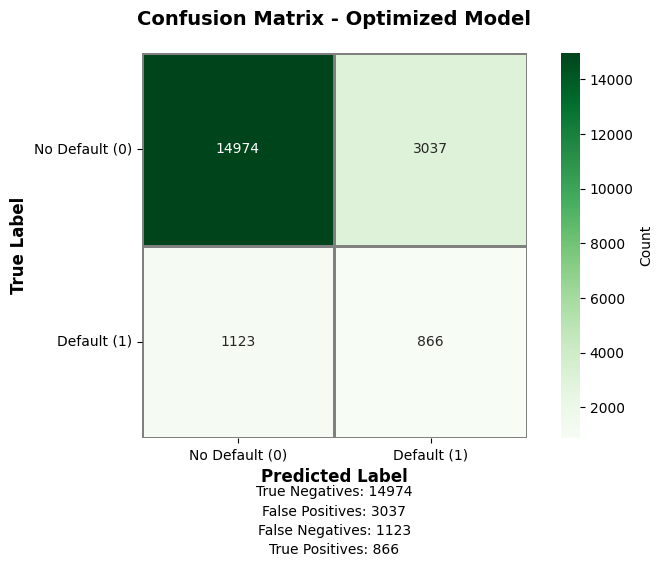


Model Metrics:
Accuracy:  0.7920 (79.20%)
Precision: 0.2219 (22.19%)
Recall:    0.4354 (43.54%)
F1-Score:  0.2940 (29.40%)


In [8]:
plot_confusion_matrix(y_test, y_pred, cmap="Greens")

In [9]:
compute_and_store_metrics(y_test, y_pred, model_name="Random Forest")

In [10]:
# Final training on the entire dataset
model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    max_features=best_params["max_features"],
    class_weight=best_params["class_weight"],
)
model.fit(X, y)
save_model(model, model_name="random_forest")